In [38]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import squarify
import plotly.express as px

# импортируем библиотеки для оценки тональности отзывов
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
nltk.downloader.download('vader_lexicon')

#импортируем библиотеки для кодирования признаков
import category_encoders as ce

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[nltk_data] Error loading vader_lexicon: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


In [39]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [40]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# 1. Загрузка и знакомство с данными

In [41]:
# Подгрузим наши данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [42]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [43]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


Так как целевым показетелем является оценка отеля посетителями, посмотрим на ее распределение в тренировочном датасете.

Text(0.5, 1.0, 'Распределение оценок')

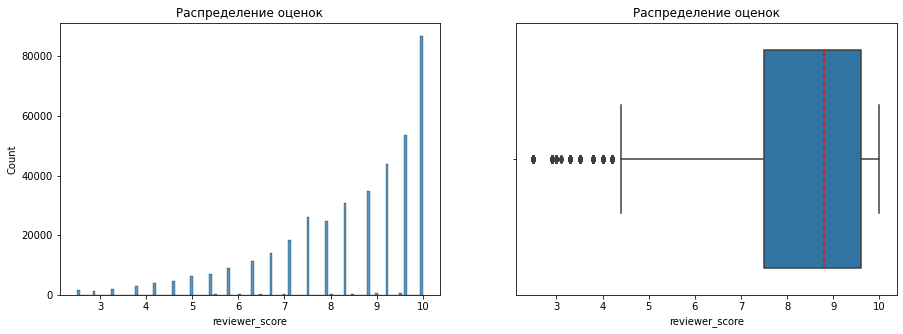

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(
    data = df_train, 
    x = 'reviewer_score', 
    ax=axes[0]
    )
axes[0].set_title('Распределение оценок')
sns.boxplot(
    data=df_train, 
    x = 'reviewer_score',
    medianprops={"color": "red", "linestyle": '--'}, 
    ax=axes[1]
    )
axes[1].set_title('Распределение оценок')

Графики показывает, что количество оценок увеличивается вместе с их значением. Низких оценок в десятки раз меньше, чем высоких. На коробчатой диаграмме оценки ниже 4.5 представлены как выбросы. Больше всего оценок со значением от 7 до 10.

In [45]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [46]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [47]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [48]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [49]:
# удаляем дубликаты из train последовательности
dupl_columns = list(df_train.columns)
mask = df_train.duplicated(subset = dupl_columns)
data_duplicates = df_train[mask]
df_train = df_train.drop_duplicates(subset=dupl_columns)

In [50]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

# 2. Анализ данных.

In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 

Только два признака имеют пропущенные данные - это призаки, указывающие локацию отеля lat и lng.

In [52]:
data.describe(include = ['object'])

,hotel_address,review_date,hotel_name,reviewer_nationality,negative_review,positive_review,tags,days_since_review
count,515431,515431,515431,515431,515431,515431,515431,515431
unique,1493,731,1492,227,330011,412601,55242,731
top,163 Marsh Wall Docklands Tower Hamlets London ...,8/2/2017,Britannia International Hotel Canary Wharf,United Kingdom,No Negative,No Positive,"[' Leisure trip ', ' Couple ', ' Double Room '...",1 days
freq,4789,2584,4789,245165,127816,35924,5101,2584


## 2.1 Названия и адреса отелей.

## Этот и следующий раздел неактуальны, так как признаки были удалены перед обучением.

В наборе данных 1493 различных адреса и 1492 различных отеля, все с уникальными названиями. Это может означать, что один отель имеет два адреса. Но сначала проверим есть ли в данных отели с одинаковым названием и разными адресами, т.е. разные отели.

Проверяем наличие одинаковых имен у разных отелей с разными адресами. 

In [53]:
# Группируем данные, чтобы получить отели одинаковым названием и разными адресами
#grouped = data.groupby(['hotel_name', 'hotel_address'])['hotel_name'].count()
#grouped = grouped.groupby('hotel_name').count().sort_values(ascending=False).head(3)

# Инициализируем название отеля и количество его адресов
#duplicated_hotel_name = grouped.index[0]
#number_duplicated_names = grouped[0]

#display('В данных '+str(number_duplicated_names)+' отеля \''+duplicated_hotel_name+\
  #    '\' с разными адресами:')

#data[data['hotel_name'] == duplicated_hotel_name][['hotel_name', 'hotel_address']].value_counts()

В датасете есть три отеля с названием Hotel Regina в разных городах.

In [54]:
# Переименуем отели, чтобы имена всех отелей были уникальными -  добавим к названию отеля часть адреса.
#data['hotel_name'] = data.apply(lambda x: (x['hotel_name'] + ' in ' + x['hotel_address'].split()[-1])
 #   if (x['hotel_name'] in duplicated_hotel_name) else x['hotel_name'], axis=1)
#display(data['hotel_name'].nunique())

Теперь в данных 1493 различных адреса и 1494 различных отеля с уникальными названиями. Это означает, что два отеля имеют один и тот же адрес. Это никак не скажется на итоговом результате.

## 2.2 Пропуски в координатах.

Заполним пропуски в координатах отелей. Скорее всего пропуски по геоданным у одних и тех же отелей

In [55]:
# Проверяем, что пропуски по геоданным у одних и тех же записей.
# Данные где одновременно присутствует пропуски по обоим признакам,
# отняли от общего количества записей и количество оставшихся записей точно равно данным из data.info()
#data[(data.lng.isna()) & (data.lat.isna())].shape[0] - data.shape[0]

In [56]:
# Группируем по отелям, чтобы посмотреть у каких отелей отсутствуют геоданные
#hotels_without_coor = data[data.lng.isna() & data.lat.isna()].groupby(by = ['hotel_address','hotel_name']).\
#  count().iloc[:,0].to_frame().reset_index()
#display(f'Геоданные отсутствуют у {hotels_without_coor.shape[0]} отелей:')
#hotels_without_coor

Так как данные с координатами отсутствуют всего у 17 отелей, заменим их в ручном режиме.

In [57]:
#hotels_without_coor[['lat','lng']] = 0
#hotels_without_coor.loc[0,['lat','lng']] = ['48.8399957','2.3070823']
#hotels_without_coor.loc[1,['lat','lng']] = ['48.8889127','2.3309643']
#hotels_without_coor.loc[2,['lat','lng']] = ['48.8753208','2.3212033']
#hotels_without_coor.loc[3,['lat','lng']] = ['41.391552','2.1757053']
#hotels_without_coor.loc[4,['lat','lng']] = ['48.2208555','16.3644228']
#hotels_without_coor.loc[5,['lat','lng']] = ['48.233592','16.3434781']
#hotels_without_coor.loc[6,['lat','lng']] = ['48.2094054','16.3512565']
#hotels_without_coor.loc[7,['lat','lng']] = ['48.2095525','16.3492746']
#hotels_without_coor.loc[8,['lat','lng']] = ['48.1888183','16.381591']
#hotels_without_coor.loc[9,['lat','lng']] = ['48.1868142','16.418528']
#hotels_without_coor.loc[10,['lat','lng']] = ['41.3749946','2.1102353']
#hotels_without_coor.loc[11,['lat','lng']] = ['48.219573','16.2834034']
#hotels_without_coor.loc[12,['lat','lng']] = ['41.3832425','2.1607609']
#hotels_without_coor.loc[13,['lat','lng']] = ['48.2458909','16.3397395']
#hotels_without_coor.loc[14,['lat','lng']] = ['48.2135906','16.3777195']
#hotels_without_coor.loc[15,['lat','lng']] = ['48.2168032','16.357717']
#hotels_without_coor.loc[16,['lat','lng']] = ['48.220414','16.3536299']

# Установим адрес как индекс, для последующего применения метода map
#hotels_without_coor.set_index('hotel_address', inplace=True)

In [58]:
# Функция для заполнения пропусков в геоданных
#def add_missing_coors(address, data_dict):
#  """
#  Входной параметр адрес, используется для поиска lng, lat в поданном вторым аргументов dataframe.
#  Адрес в dataframe является индеком

#  Args:
#      address (str): строка с адресом отеля
 #     data_dict (pd.Dataframe()): Dataframe с lng, lat в качестве признаков и адресом в качестве индекса

 # Returns:
#      pd.Series(): возвращает lng, ltd
#  """
 # if address in data_dict.index:
  #  return pd.Series([data_dict.loc[address].lat, data_dict.loc[address].lng],
 #                    index = ['lat','lng'])

In [59]:
# Преобразуем записи, у которых есть пропуски по геоданным, и заполняем их данными в соотвествии с указанными выше геокоординатами
#data.loc[data[(data.lat.isna() | data.lng.isna())].index,['lat','lng']] = \
#data[data.lat.isna() | data.lng.isna()].loc[:].\
#  apply(lambda x: add_missing_coors(x.hotel_address, hotels_without_coor), axis = 1)

In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 

В датасете больше нет признаков с пропусками. Так же все отели имеют уникальные названия.

# 3. Создание признаков.

## 3.1 Город и страна отеля

Выделим в отдельные признаки город и страну, в которых находятся отели.

In [61]:
data['hotel_address'].head(10)

0                   Via Senigallia 6 20161 Milan Italy
1    Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...
2          Mallorca 251 Eixample 08008 Barcelona Spain
3    Piazza Della Repubblica 17 Central Station 201...
4    Singel 303 309 Amsterdam City Center 1012 WJ A...
5    Coram Street Camden London WC1N 1HT United Kin...
6    Empire Way Wembley Brent London HA9 8DS United...
7    1 Shortlands Hammersmith and Fulham London W6 ...
8          35 Rue Caumartin 9th arr 75009 Paris France
9    49 Gloucester Place Marble Arch Westminster Bo...
Name: hotel_address, dtype: object

Страна - это последнее слово в адресе отеля, кроме Великобритании - у нее два слова в конце. Город это предпоследнее слово в адресе, кроме адресов в Великобритании.

In [62]:
# Создаем новый признак - страну, в которой находится отель
data['hotel_country'] = data['hotel_address'].apply(lambda x: 'United Kingdom' if x.split()[-1] == 'Kingdom' else x.split()[-1])

In [63]:
# Создаем новый признак - город, в котором находится отель
data['hotel_city'] = data['hotel_address'].apply(lambda x: 'London' if x.split()[-1] == 'Kingdom' else x.split()[-2])

In [64]:
data['hotel_city'].value_counts()

London       262300
Barcelona     60149
Paris         59626
Amsterdam     57212
Vienna        38938
Milan         37206
Name: hotel_city, dtype: int64

In [65]:
data['hotel_country'].value_counts()

United Kingdom    262300
Spain              60149
France             59626
Netherlands        57212
Austria            38938
Italy              37206
Name: hotel_country, dtype: int64

Мы видим, что стран, в которых находятся отели 6 и городов столько же. В каждой стране отели находится в одном городе. Проверим различаются ли средние значения оценок в городе и стране, в которой он находится.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<function matplotlib.pyplot.show(close=None, block=None)>

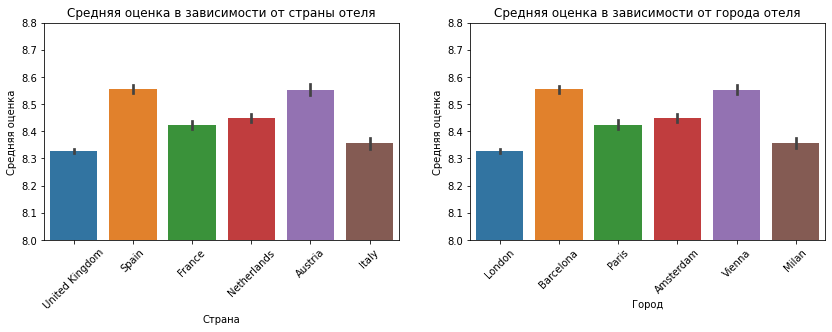

In [66]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Строим столбчатые диаграммы для визуализации средней оценки в зависимости от города и страны, в которых расположены отели
sns.barplot( 
            data[data['sample']==1]['hotel_country'],
            data[data['sample']==1]['reviewer_score'],
            order=["United Kingdom", "Spain", "France", 'Netherlands', 'Austria', 'Italy'],
            ax=axes[0]
            )
axes[0].set(xlabel='Страна', ylabel='Средняя оценка')
axes[0].xaxis.set_tick_params(rotation = 45)
axes[0].set_title('Средняя оценка в зависимости от страны отеля')
axes[0].set_ylim(8, 8.8)

sns.barplot( 
            data[data['sample']==1]['hotel_city'],
            data[data['sample']==1]['reviewer_score'],
            order=["London", "Barcelona", "Paris", 'Amsterdam', 'Vienna', 'Milan'],
            ax=axes[1]
            )
axes[1].set(xlabel='Город', ylabel='Средняя оценка')
axes[1].xaxis.set_tick_params(rotation = 45)
axes[1].set_title('Средняя оценка в зависимости от города отеля')
axes[1].set_ylim(8, 8.8)

plt.show

Данные в обоих графиках одинаковые. Так как признаки повторяют друг друга оставим только один из них - hotel_country.

In [67]:
data = data.drop(['hotel_city'], axis = 1)

## 3.2 Количество дней между датой проверки и очистки.

Данные в признаке days_since_review имеют тип object. Преобразуем их в число.

In [68]:
data['days_since_review'].head(5)

0    13 days
1    234 day
2    616 day
3    656 day
4    444 day
Name: days_since_review, dtype: object

In [69]:
# Выделяем из признака числовую часть
data['days_since_review'] = data['days_since_review'].apply(lambda x: x.split()[0])

In [70]:
# Изменяем тип данных на числовой
data['days_since_review'] = data['days_since_review'].astype('int64')

In [71]:
data['days_since_review'].describe()

count    515431.000000
mean        354.405492
std         208.915335
min           0.000000
25%         175.000000
50%         353.000000
75%         527.000000
max         730.000000
Name: days_since_review, dtype: float64

## 3.3 Национальность рецензента

In [72]:
data['reviewer_nationality'].describe()

count               515431
unique                 227
top        United Kingdom 
freq                245165
Name: reviewer_nationality, dtype: object

Признак reviewer_nationality имеет более 200 уникальных значений. 

In [73]:
# распределение гостей по национальностям
df_nationality = pd.DataFrame(data[data['sample']==1]['reviewer_nationality'].value_counts())
fig = px.choropleth(
    locations = df_nationality.index,
    locationmode = 'country names',
    color = np.log(df_nationality['reviewer_nationality']),
    color_continuous_scale=px.colors.sequential.Plasma
    )

fig.show()

Большинство рецензентов живут в Великобритании. Так же можно выделить Европу, США, Россию, Австралию и крупные восточные страны. Уменьшим количество стран, выберем наиболее часто встречающиеся, а остальные обозначим как other.

In [74]:
# Создаем Series с национальностями рецензентов и их долями
data_reviewer_nationality_count = (data['reviewer_nationality'].value_counts(normalize = True))
data_reviewer_nationality_sort = data_reviewer_nationality_count.sort_values(ascending = False)
data_reviewer_nationality_sort.describe()

count    227.000000
mean       0.004405
std        0.032086
min        0.000002
25%        0.000016
50%        0.000118
75%        0.001800
max        0.475650
Name: reviewer_nationality, dtype: float64

In [75]:
# Создаем список с 15 самыми популряными национальностями, значения которых более 1%. Если национальности нет среди 15 популярных, заменяем ее на other.
popular_reviewer_nationality = data_reviewer_nationality_sort.nlargest(15).index
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x if x in popular_reviewer_nationality else 'other')
data['reviewer_nationality'].describe()

count               515431
unique                  16
top        United Kingdom 
freq                245165
Name: reviewer_nationality, dtype: object

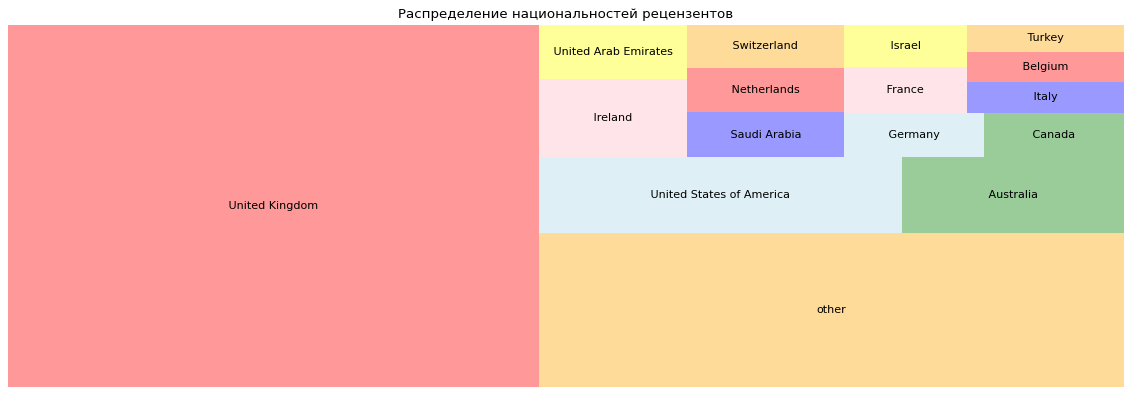

In [76]:
# Строим иерархическую диаграмму с распределением национальностей
plt.figure(figsize=(18,6), dpi= 80)
squarify.plot(sizes = (data['reviewer_nationality'].value_counts()).values, 
              label = (data['reviewer_nationality'].value_counts()).index, 
              alpha=.4, 
              color = ['red','orange','lightblue','green','pink','yellow', 'blue'])

plt.title('Распределение национальностей рецензентов')
plt.axis('off')
plt.show()

Большинство рецензентов из Великобритании. Вторым по величине стало объединенное количество рецензентов из других стран.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



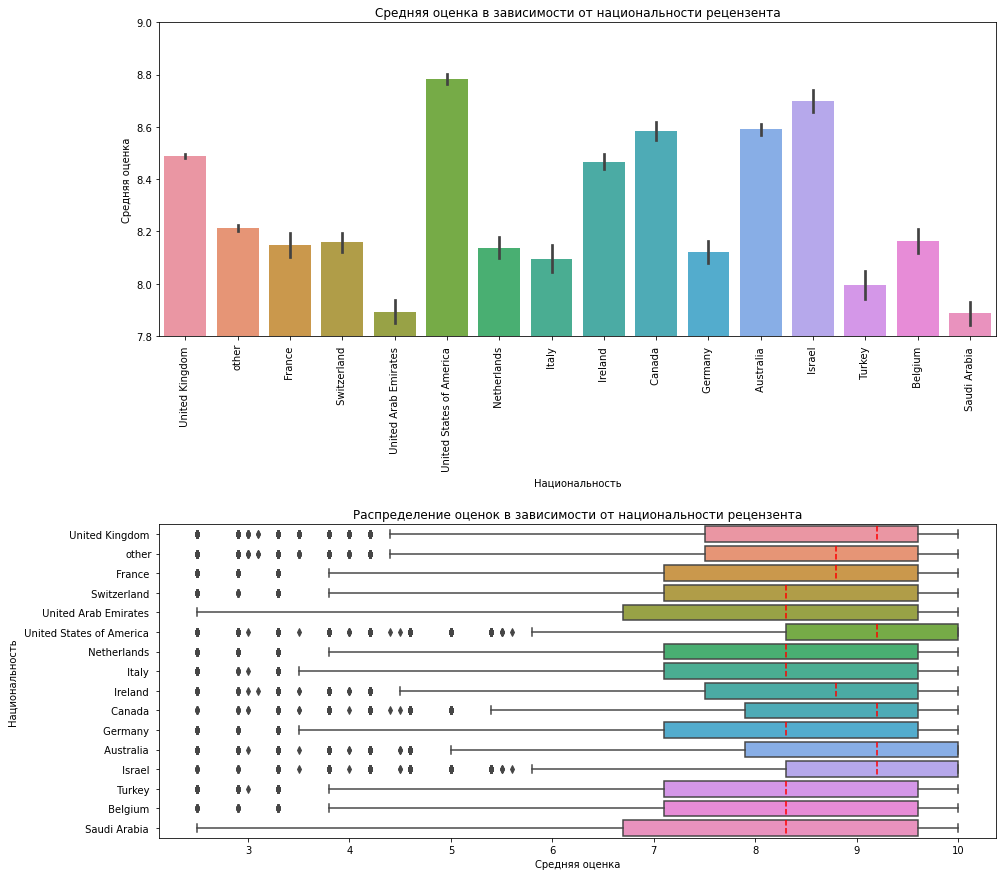

In [77]:
fig, axes = plt.subplots(2, 1, figsize=(15, 15))
plt.subplots_adjust(hspace=0.6)

# Строим столбчатую диаграмму для визуализации средней оценки в зависимости от национальности рецензента
sns.barplot( 
            data[data['sample']==1]['reviewer_nationality'],
            data[data['sample']==1]['reviewer_score'],
            ax=axes[0]
            )
axes[0].set(xlabel='Национальность', ylabel='Средняя оценка')
axes[0].xaxis.set_tick_params(rotation = 90)
axes[0].set_title('Средняя оценка в зависимости от национальности рецензента')
axes[0].set_ylim(7.8, 9)

# Строим коробчатую диаграмму для визуализации распределения оценкок в зависимости от национальности рецензента
sns.boxplot(
            data[data['sample']==1]['reviewer_score'], 
            data[data['sample']==1]['reviewer_nationality'],
            medianprops={"color": "red", "linestyle": '--'},
            ax=axes[1]
            )
axes[1].set(xlabel='Средняя оценка', ylabel='Национальность')
axes[1].set_title('Распределение оценок в зависимости от национальности рецензента')

plt.show()

Средняя оценка изменяется в зависимости от национальности рецензента. Посетители из арабских стран ставят более низкие оценки.

Посетитиели из Австралии, Израиля и США ставят более высокие оценки по сравнению с посетителями из других стран. 


## 3.4 Теги

Разберем признак tags, разделим его на группы: количество проведенных ночей, цель поездки, вид номера и т.д.

In [78]:
data['tags'].head()

0    [' Leisure trip ', ' Couple ', ' Double Room '...
1    [' Leisure trip ', ' Group ', ' Triple Room ',...
2    [' Business trip ', ' Solo traveler ', ' Twin ...
3    [' Leisure trip ', ' Couple ', ' Ambassador Ju...
4    [' Business trip ', ' Solo traveler ', ' Class...
Name: tags, dtype: object

In [79]:
# Создаем функцию для разделения тегов
def tag_separation(tags):
    """
  Входной параметр тег.
  Тег в dataframe является списком строк

  Args:
      num_tags: список строк с тегами, разделенных запятой и имеющих пробелы в начале и конце строки

  Returns:
      pd.Series(): возвращает список тегов
  """
    tags = tags[2:-2]
    result = tags.strip().split(' \', \' ')
    return result

data['tags_new'] = data['tags'].apply(tag_separation)

In [80]:
data['tags_new'].head()

0    [Leisure trip, Couple, Double Room, Stayed 2 n...
1    [Leisure trip, Group, Triple Room, Stayed 1 ni...
2    [Business trip, Solo traveler, Twin Room, Stay...
3    [Leisure trip, Couple, Ambassador Junior Suite...
4    [Business trip, Solo traveler, Classic Double ...
Name: tags_new, dtype: object

### 3.4.1 Цель поездки

In [81]:
# Создаем функцию для выделения тега с целью поездки
def find_trip(row):
    """
 Входной параметр тег.
 Тег в dataframe является списком

 Args:
    row: список тегов
 Returns:
    pd.Series(): возвращает тег (строку) - цель поездки
 """
    for tag in row:
        if 'trip' in tag:
            return tag
    return 'Unkown trip'

data['purpose_of_the_trip'] = data['tags_new'].apply(find_trip)

In [82]:
# Получаем объект Series с распределением целей поездки
purpose_counts = data[data['sample']==1]['purpose_of_the_trip'].value_counts()

Несмотря на то, что преобладающими являются поездки на отдых

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



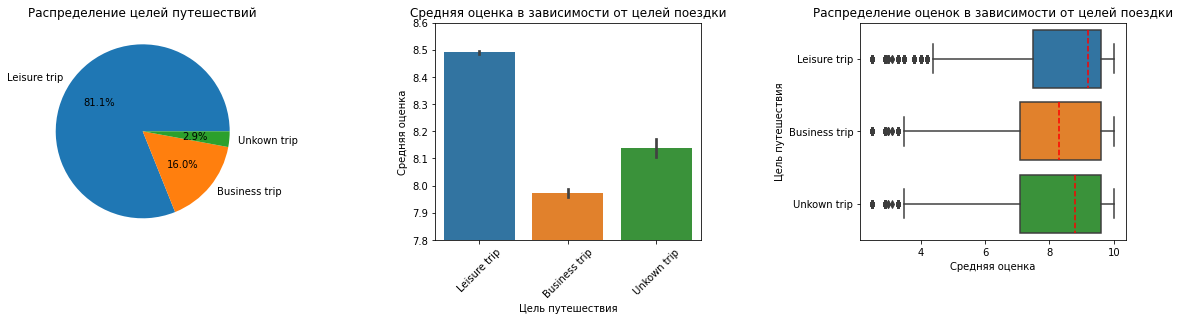

In [83]:
fig, axes = plt.subplots(1, 3, figsize=(20, 4))
plt.subplots_adjust(wspace=0.6)

# Строим круговую диаграмму с рапределением целей поездки
axes[0].pie(
            purpose_counts, 
            labels = purpose_counts.index, 
            autopct = '%.1f%%'
            )
axes[0].set_title('Распределение целей путешествий')

# Строим столбчатую диаграмму для визуализации средней оценки в зависимости от целей поездки
sns.barplot( 
            data[data['sample']==1]['purpose_of_the_trip'],
            data[data['sample']==1]['reviewer_score'],
            ax=axes[1]
            )
axes[1].set(xlabel='Цель путешествия', ylabel='Средняя оценка')
axes[1].xaxis.set_tick_params(rotation = 45)
axes[1].set_title('Средняя оценка в зависимости от целей поездки')
axes[1].set_ylim(7.8, 8.6)

# Строим коробчатую диаграмму для визуализации распределения оценок в зависимости от целей поездки
sns.boxplot(
            data[data['sample']==1]['reviewer_score'], 
            data[data['sample']==1]['purpose_of_the_trip'],
            medianprops={"color": "red", "linestyle": '--'},
            ax=axes[2]
            )
axes[2].set(xlabel='Средняя оценка', ylabel='Цель путешествия')
axes[2].set_title('Распределение оценок в зависимости от целей поездки')

plt.show()

In [84]:
data['purpose_of_the_trip'].describe()

count           515431
unique               3
top       Leisure trip
freq            417538
Name: purpose_of_the_trip, dtype: object

Средняя оценка именяется в зависимости от целей путешествия. Распределение оценок не сильно отличается для различных путешествий. Можно отметить только более сильное различие медианного значения оценок.

In [85]:
display('Целей поездки всего {}. Наиболее часто встречающийся тип поездки {}. Признак категориальный, номинальный'.format(data['purpose_of_the_trip'].describe().loc['unique'],data['purpose_of_the_trip'].describe().loc['top']))

'Целей поездки всего 3. Наиболее часто встречающийся тип поездки Leisure trip. Признак категориальный, номинальный'

### 3.4.2 Количество дней проживания в отеле

In [86]:
# Создаем функцию для выделения из тегов количества дней проживания в отеле
def find_night(row):
    """
  Входной параметр тег.
  Тег в dataframe является списком

  Args:
      row: список тегов

  Returns:
      pd.Series(): возвращает число - количество дней проживания в отеле
  """
    for tag in row:
        if 'Stayed' in tag:
            return tag.split()[1]
    return None

data['night_in_hotel'] = data['tags_new'].apply(find_night)

In [87]:
data['night_in_hotel'].describe()

count     515239
unique        31
top            1
freq      193568
Name: night_in_hotel, dtype: object

In [88]:
display('Посетители отеля проводят в нем чаще всего {} ночь.'.format(data['night_in_hotel'].describe().loc['top']))

'Посетители отеля проводят в нем чаще всего 1 ночь.'

### 3.4.3 Вид номера

In [89]:
# Создаем функцию для выделения тегов с видом номера
def find_room(row):
    """
  Входной параметр тег.
  Тег в dataframe является списком

  Args:
      row: список тегов

  Returns:
      pd.Series(): возвращает тег (строку) - вид номера
  """
    for tag in row:
        if len(row)>2:
            if 'trip' in tag:
                return row[2]
            else:
                return row[1]
        if len(row)<=2:
            return None

data['room'] = data['tags_new'].apply(find_room)

In [90]:
data['room'].describe()

count          515340
unique           2393
top       Double Room
freq            35124
Name: room, dtype: object

In [91]:
data['room'].value_counts()

Double Room                                     35124
Standard Double Room                            32174
Superior Double Room                            31272
Deluxe Double Room                              24754
Double or Twin Room                             22311
                                                ...  
Executive Suite Free Executive Lounge Access        1
Deluxe Pantheon Room                                1
Duplex King Suite 3 Adults                          1
Suite Free Executive Lounge Access                  1
Quadruple Room 2 Adults 2 Children                  1
Name: room, Length: 2393, dtype: int64

In [92]:
display('Всего {} уникальных типа номера. Наиболее часто встречающийся {}. Признак категориальный, номинальный, имеет пропуски. Требует дальнейшего преобразования'.format(data['room'].describe().loc['unique'],data['room'].describe().loc['top']))

'Всего 2393 уникальных типа номера. Наиболее часто встречающийся Double Room. Признак категориальный, номинальный, имеет пропуски. Требует дальнейшего преобразования'

### 3.4.4 Статус клиента

In [93]:
# Создаем функцию для выделения тега, отражающего статус клиентов отеля
def find_status(row):
    """
 Входной параметр тег.
 Тег в dataframe является списком

 Args:
    row: список тегов
 Returns:
    pd.Series(): возвращает тег (строку) - статус клиентов отеля
 """
    for tag in row:
        if 'trip' in tag:
            return row[1]
        else:
            return row[0]

data['status'] = data['tags_new'].apply(find_status)

In [94]:
# Получаем объект Series с распределением статуса клиента
status_counts = data[data['sample']==1]['status'].value_counts()

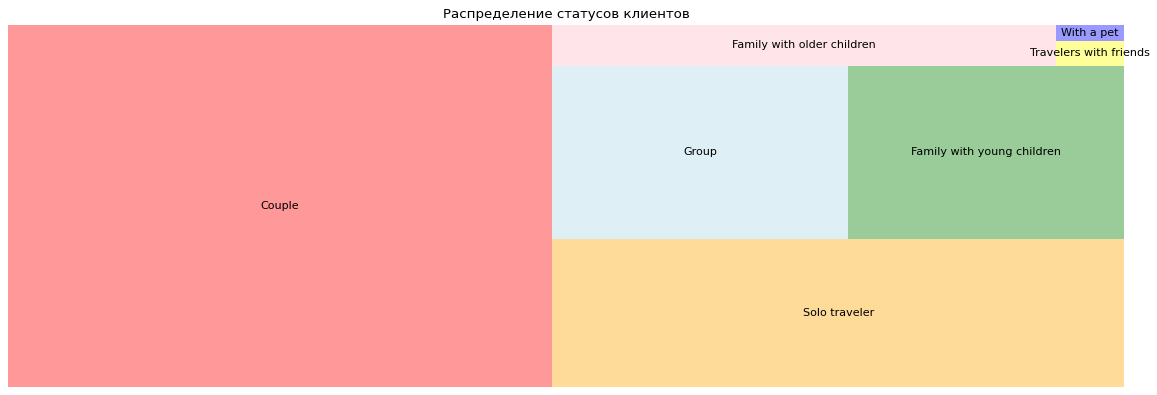

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



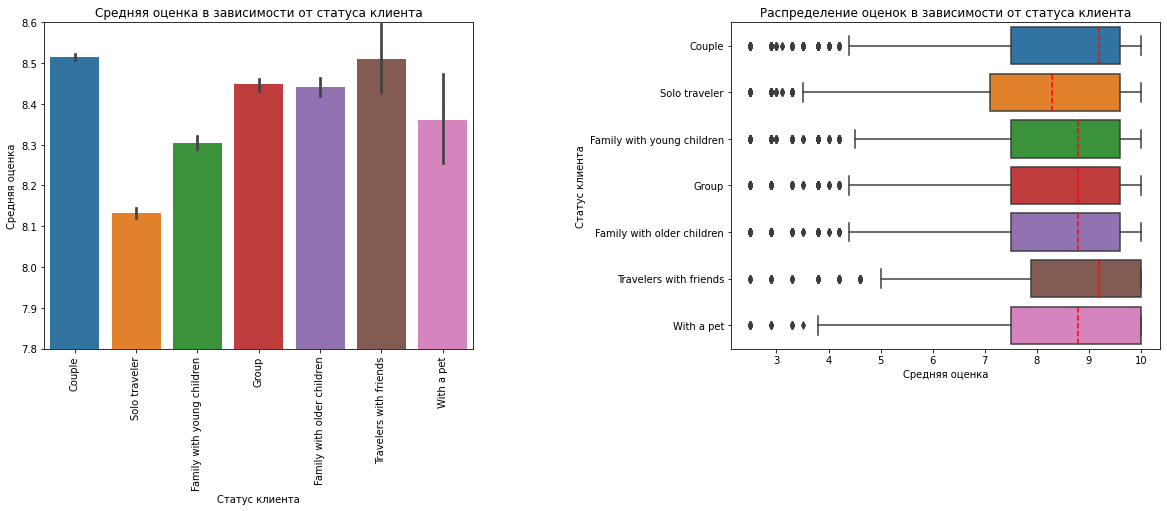

In [95]:
# Строим иерархическую диаграмму с рапределением статусов клиентов
plt.figure(figsize=(18,6), dpi= 80)
squarify.plot(
              sizes = (data[data['sample']==1]['status'].value_counts()).values, 
              label = (data['status'].value_counts()).index, 
              alpha=.4, 
              color = ['red','orange','lightblue','green','pink','yellow', 'blue']
             )
plt.title('Распределение статусов клиентов')
plt.axis('off')
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(20, 6))
plt.subplots_adjust(wspace=0.6)

# Строим столбчатую диаграмму для визуализации средней оценки в зависимости от статуса клиента
sns.barplot( 
            data[data['sample']==1]['status'],
            data[data['sample']==1]['reviewer_score'],
            ax=axes[0]
            )
axes[0].set(xlabel='Статус клиента', ylabel='Средняя оценка')
axes[0].xaxis.set_tick_params(rotation = 90)
axes[0].set_title('Средняя оценка в зависимости от статуса клиента')
axes[0].set_ylim(7.8, 8.6)

# Строим коробчатую диаграмму для визуализации распределения оценок в зависимости от статуса клиента
sns.boxplot(
            data[data['sample']==1]['reviewer_score'], 
            data[data['sample']==1]['status'],
            medianprops={"color": "red", "linestyle": '--'},
            ax=axes[1]
            )
axes[1].set(xlabel='Средняя оценка', ylabel='Статус клиента')
axes[1].set_title('Распределение оценок в зависимости от статуса клиента')

plt.show()

Почти половина постояльцев отелей путешествуют парами. Средние оценки имеют близкие значения у всех категорий клиентов. При этом медиана оценок у пар намного выше, чем у соло путешественников.

In [96]:
data['status'].describe()

count     515431
unique         7
top       Couple
freq      251388
Name: status, dtype: object

In [97]:
display('Всего {} уникальных статусов посетителей отеля. Наиболее часто встречающийся {}. Признак категориальный, номинальный.'.format(data['status'].describe().loc['unique'],data['status'].describe().loc['top']))

'Всего 7 уникальных статусов посетителей отеля. Наиболее часто встречающийся Couple. Признак категориальный, номинальный.'

### 3.4.5 Способ отправки отзыва

In [98]:
# Создаем функцию для выделения тега, отражающего как отправлен отзыв
def find_submitted(row):
    """
 Входной параметр тег.
 Тег в dataframe является списком

 Args:
    row: список тегов
 Returns:
    pd.Series(): возвращает число - 1, если отзыв отправлен с мобильного приложения, 0 - если нет
 """
    for tag in row:
        if 'Submitted' in tag:
            return 1
    return 0

data['how_sent'] = data['tags_new'].apply(find_submitted)

In [99]:
# Получаем объект Series с распределением целей поездки
how_sent_counts = data[data['sample']==1]['how_sent'].value_counts()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



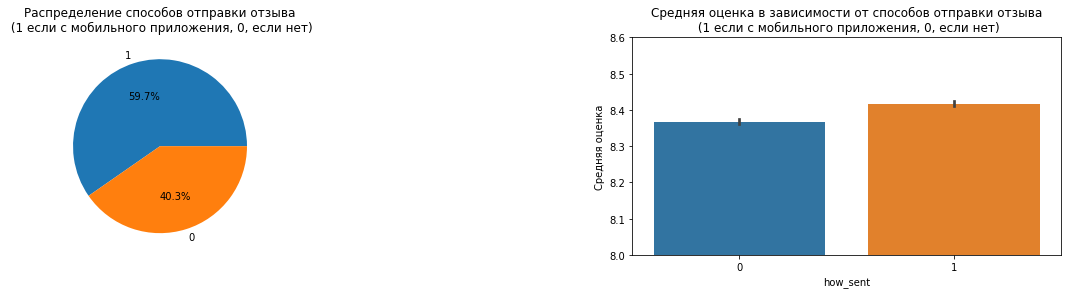

In [100]:
fig, axes = plt.subplots(1, 2, figsize=(20, 4))
plt.subplots_adjust(wspace=0.6)

# Строим круговую диаграмму с рапределением способов отправки отзыва
axes[0].pie(
            how_sent_counts, 
            labels = how_sent_counts.index, 
            autopct = '%.1f%%'
            )
axes[0].set_title('Распределение способов отправки отзыва\n (1 если с мобильного приложения, 0, если нет)')

# Строим столбчатую диаграмму для визуализации средней оценки в зависимости от способов отправки отзыва
sns.barplot( 
            data[data['sample']==1]['how_sent'],
            data[data['sample']==1]['reviewer_score'],
            ax=axes[1]
            )
axes[1].set(ylabel='Средняя оценка')
axes[1].set_title('Средняя оценка в зависимости от способов отправки отзыва\n (1 если с мобильного приложения, 0, если нет)')

plt.ylim(8, 8.6)
plt.show()

Большинство клиентов отправляют отзыв с мобильного приложения, при этом на среднюю оценку способ ее отправки почти не влияет.

## 3.5 Пропуски в новых столбцах

In [101]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 25 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 

Признаки night_in_hotel и room имеют пропуски.

In [102]:
# Вычисляем количество пропусков для признака night_in_hotel
null_percent = round(data['night_in_hotel'].isnull().mean()*100,3)
display(f'Количество пропусков {null_percent}')

'Количество пропусков 0.037'

Так как пропуков в столбце night_in_hotel немного (3.7%), заполним их медианой от количества дней, проведенных в отеле другими клиентами.

In [103]:
# В столбце night_in_hotel заполним пропуски медианой и преобразуем тип данных в числовой
data['night_in_hotel'] = data['night_in_hotel'].fillna(data['night_in_hotel'].median())
data['night_in_hotel'] = data['night_in_hotel'].astype('int64')

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



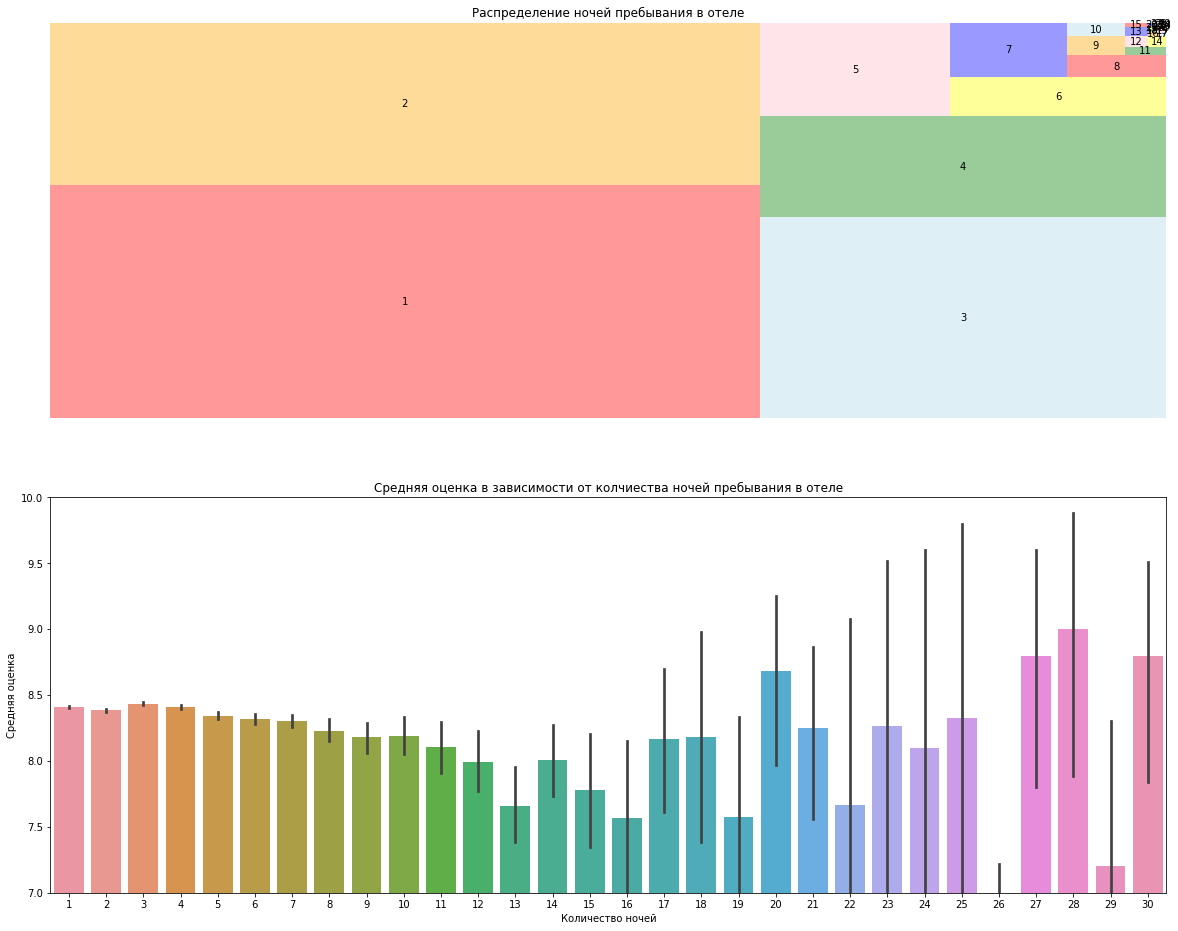

In [104]:
fig, axes = plt.subplots(2, 1, figsize=(20, 16))

# Строим иерархическую диаграмму с распределением ночей пребывания в отеле
squarify.plot(
              sizes = (data[data['sample']==1]['night_in_hotel'].value_counts()).values, 
              label = (data['night_in_hotel'].value_counts()).index, 
              alpha=.4, 
              color = ['red','orange','lightblue','green','pink','yellow', 'blue'],
              ax=axes[0]
             )

axes[0].set_title('Распределение ночей пребывания в отеле')
axes[0].axis('off')

# Строим столбчатую диаграмму для визуализации средней оценки в зависимости от колчиества ночей пребывания в отеле
sns.barplot( 
            data[data['sample']==1]['night_in_hotel'],
            data[data['sample']==1]['reviewer_score'],
            ax=axes[1]
            )
axes[1].set(xlabel='Количество ночей', ylabel='Средняя оценка')
axes[1].set_title('Средняя оценка в зависимости от колчиества ночей пребывания в отеле')

plt.ylim(7, 10)
plt.show()

Число посетителей уменьшается с увеличением количества ночей, которые они провели в отеле. Посетителей, которые провели в отеле более 15 ночей - незначительное количество. Так же средние оценки таких посетителей отличаются от тех, кто провел в отеле меньшее количество ночей, в них наблюдается значительный разброс.

Средняя оценка рецензенотов, которые останавливались в отеле от 1 до 14 ночей постепенно уменьшается с увеличением количества проведенных ночей. У посетителей, которые жили в отеле больше 15 дней средние оценки очень разнятся, сложно выделить какую-то закономерность.

In [105]:
# Вычисляем количество пропусков для признака room
null_percent = round(data['room'].isnull().mean()*100,3)
display(f'Количество пропусков {null_percent}')

'Количество пропусков 0.018'

Так как пропуков в столбце night_in_hotel немного (1.8%), заполним их модой, так как признак категориальный.

In [106]:
# Выделяем моду и заменяем на нее пропуски
mode_room_type = data['room'].mode()[0] 
data['room'].fillna(mode_room_type, inplace=True)

In [107]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 25 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 

Пропусков больше нет.

## 3.6  Признак room

Признак room имеет более 2000 уникальных значений. Уменьшим их количество, выберем наиболее часто встречающиеся, а остальные обозначим как other.

In [108]:
# Создаем Series с типами номеров и их долей среди всех типов
data_room_count = (data['room'].value_counts(normalize = True))
data_room_sort = data_room_count.sort_values(ascending = False)
display(data_room_sort)

Double Room                                                              0.068321
Standard Double Room                                                     0.062422
Superior Double Room                                                     0.060672
Deluxe Double Room                                                       0.048026
Double or Twin Room                                                      0.043286
                                                                           ...   
Junior Suite Attic                                                       0.000002
Executive Double Room Eiffel Tower View with 1 Queensize and Sofa Bed    0.000002
Suite with Balcony and Spa Access                                        0.000002
Comfort Plus Twin Room                                                   0.000002
Quadruple Room 2 Adults 2 Children                                       0.000002
Name: room, Length: 2393, dtype: float64

Выберем 30 самых популярных типов номеров, остальные обозначим other.

In [109]:
# Создаем список с 30 самыми популряными номерами. Если типа номера нет среди 30 популярных, заменяем его на other.
popular_type_room = data_room_sort.nlargest(30).index
data['room'] = data['room'].apply(lambda x: x if x in popular_type_room else 'other')
data['room'].describe()

count     515431
unique        31
top        other
freq      194076
Name: room, dtype: object

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



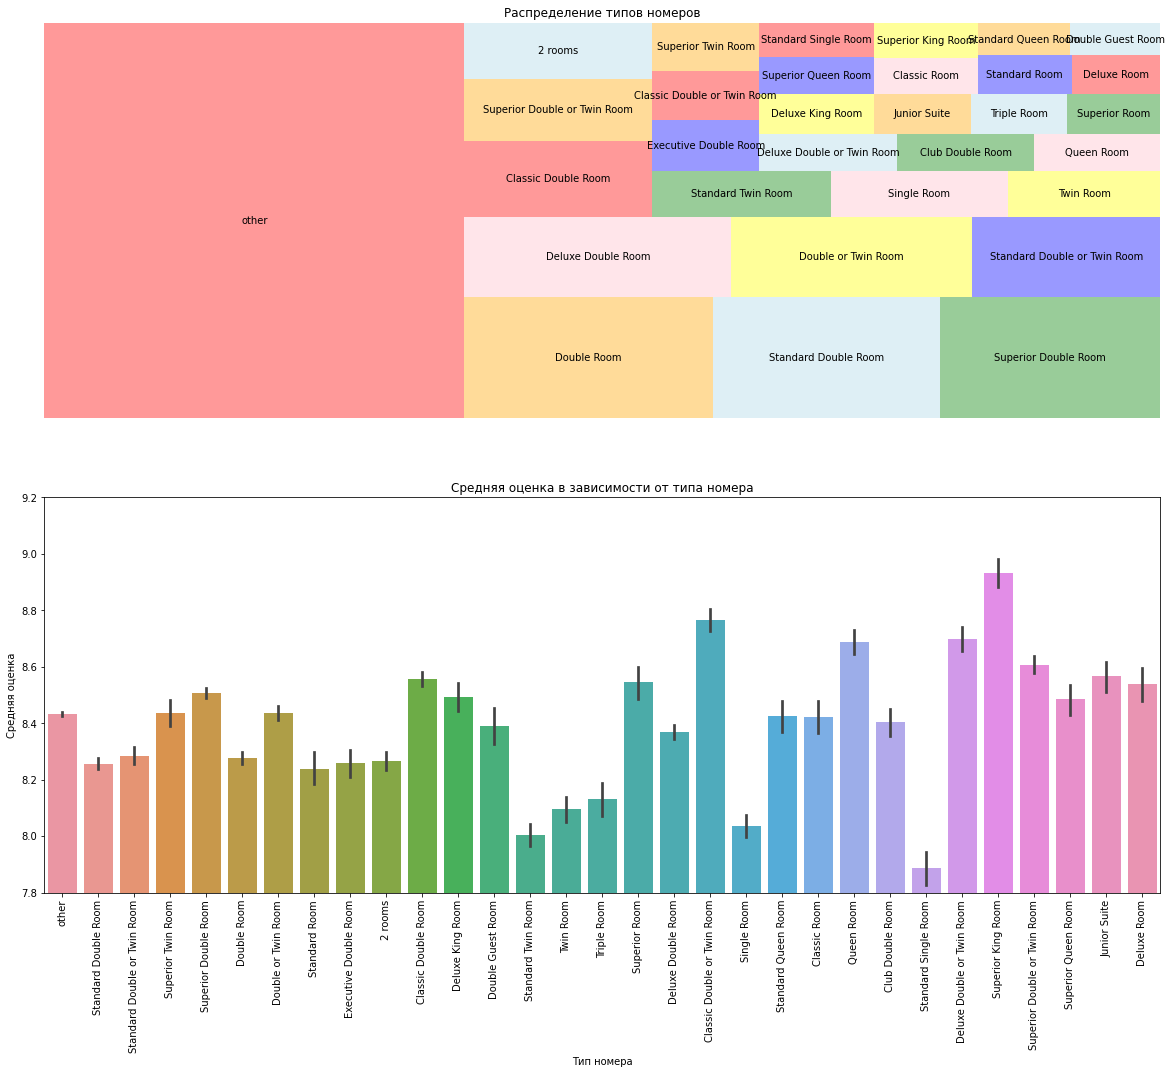

In [110]:
fig, axes = plt.subplots(2, 1, figsize=(20, 16))

# Строим иерархическую диаграмму с распределением типов номеров
squarify.plot(sizes = (data['room'].value_counts()).values, 
              label = (data['room'].value_counts()).index, 
              alpha=.4, 
              color = ['red','orange','lightblue','green','pink','yellow', 'blue'],
              ax=axes[0]
              )

axes[0].set_title('Распределение типов номеров')
axes[0].axis('off')

# Строим столбчатую диаграмму для визуализации средней оценки в зависимости от типа номера
sns.barplot( 
            data[data['sample']==1]['room'],
            data[data['sample']==1]['reviewer_score'],
            ax=axes[1]
            )
axes[1].set(xlabel='Тип номера', ylabel='Средняя оценка')
axes[1].xaxis.set_tick_params(rotation = 90)
axes[1].set_title('Средняя оценка в зависимости от типа номера')

plt.ylim(7.8, 9.2)
plt.show()

После преобразования признака, номеров, которые мы отнесли к other стало больше всех. Но средняя оценка среди 30 наиболее часто встречающихся типов номеров отличается незначительно. Есть вероятность, что типы номеров, попавшие в other, по отдельности так же не имели бы сильного отличия в средней оценке.

## 3.7 Положительные и отрицательные отзывы

In [111]:
sent_analyzer = SentimentIntensityAnalyzer()
# Создаем функцию для анализа тональности текста отзывов
def find_score_review(review):
    """
 Входной параметр отзыв.
 Отзыв в dataframe является строкой

 Args:
    review: отзыв
 Returns:
    pd.Series(): возвращает оценку тональности отзыва
 """
    result = sent_analyzer.polarity_scores(review)
    return result['compound']

data['score_negative'] = data['negative_review'].apply(find_score_review)
data['score_positive'] = data['positive_review'].apply(find_score_review)

In [112]:
data['score_negative'].describe()

count    515431.000000
mean         -0.202931
std           0.456514
min          -0.998100
25%          -0.709600
50%          -0.153100
75%           0.000000
max           0.996000
Name: score_negative, dtype: float64

In [113]:
data['score_positive'].describe()

count    515431.000000
mean          0.593839
std           0.342038
min          -0.983200
25%           0.361200
50%           0.708900
75%           0.883400
max           0.999300
Name: score_positive, dtype: float64

Text(0.5, 1.0, 'Распределение показателя позитивных отзывов')

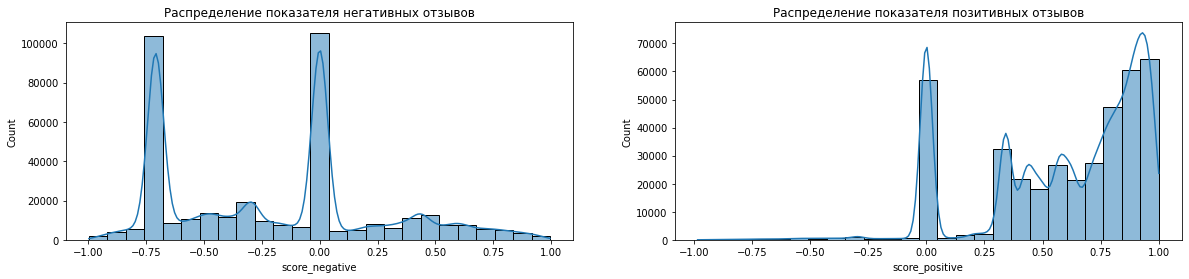

In [114]:
fig, axes = plt.subplots(1, 2, figsize=(20, 4))

# Строим столбчатую диаграмму отражающую распределение показателя негативных отзывов
sns.histplot(
    data[data['sample']==1]['score_negative'],
    bins=25,
    kde=True,
    ax=axes[0]
    )
axes[0].set_title('Распределение показателя негативных отзывов')

# Строим столбчатую диаграмму отражающую распределение показателя позитивных отзывов
sns.histplot(
    data[data['sample']==1]['score_positive'],
    bins=25,
    kde=True,
    ax=axes[1]
    )
axes[1].set_title('Распределение показателя позитивных отзывов')

Среди негативных отзывов явно выделяются два пика на значениях -0,75 и 0, которые достигают количества 100 000. Число всех остальных значений колеблется в пределах 20000.

В позитивных отзывах отрицатальных значений почти нет. Также как и в негативных есть пик на знаяении 0, но он меньше - около 60000. После 0,25 число значений увеличивается и постепенно растет, достигая максимума к 1.

## 3.8 Дата, когда посетитель оставил отзыв.

Выделим из призанака день, месяц, год, и день недели.

In [115]:
# Преобразуем признак review_date в datetime и создадим новые призанки 
data['review_date']=pd.to_datetime(data['review_date'])
data['day'] = data['review_date'].dt.day
data['month'] = data['review_date'].dt.month
data['year'] = data['review_date'].dt.year
data['dayofweek'] = data['review_date'].dt.dayofweek

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



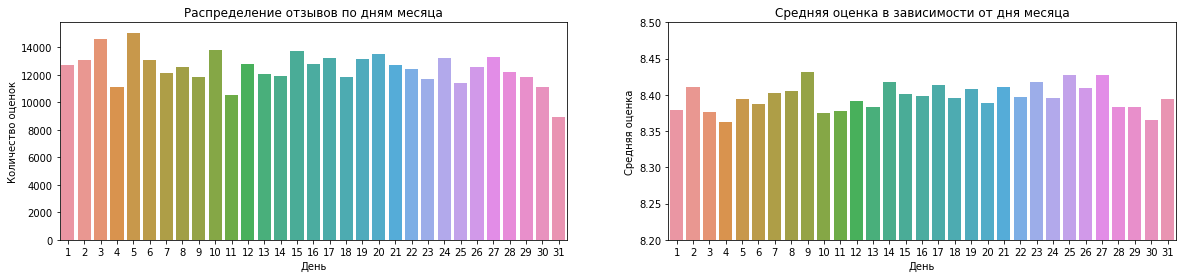

In [116]:
# Группируем данные, чтобы узнать количество отзывов по дням
groupped_day_count = data[data['sample']==1].groupby('day')['reviewer_score'].count()
# Группируем данные, чтобы узнать среднюю оценку по дням
groupped_day_mean = data[data['sample']==1].groupby('day')['reviewer_score'].mean()

fig, axes = plt.subplots(1, 2, figsize=(20, 4))

# Строим столбчатую диаграмму для визуализации количества отзывов по дням месяца
sns.barplot( 
            groupped_day_count.index,
            groupped_day_count.values,
            ax=axes[0]
            )
axes[0].set(xlabel='День', ylabel='Количество оценок')
axes[0].set_title('Распределение отзывов по дням месяца')


# Строим столбчатую диаграмму для визуализации средней оценки в зависимости от дня месяца
sns.barplot( 
            groupped_day_mean.index,
            groupped_day_mean.values,
            ax=axes[1]
            )
axes[1].set(xlabel='День', ylabel='Средняя оценка')
axes[1].set_title('Средняя оценка в зависимости от дня месяца')

plt.ylim(8.2, 8.5)
plt.show()

Какой-то зависимости количества оценок и их среднего значения от дня месяца, когда оценки были поставлены не прослеживается.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



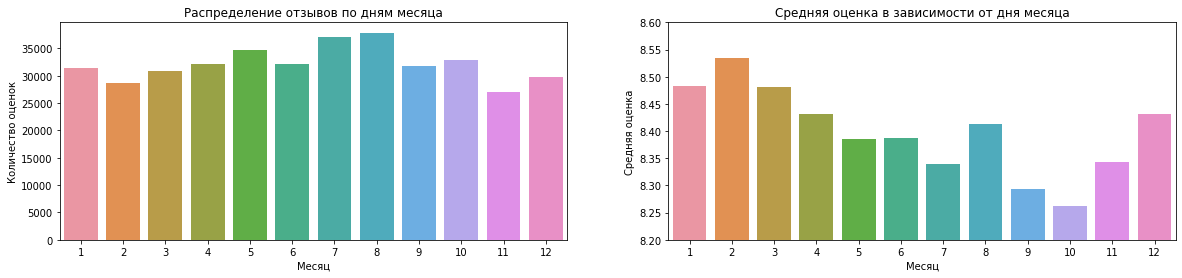

In [117]:
# Группируем данные, чтобы узнать количество отзывов по месяцам
groupped_month_count = data[data['sample']==1].groupby('month')['reviewer_score'].count()
# Группируем данные, чтобы узнать среднюю оценку по месяцам
groupped_month_mean = data[data['sample']==1].groupby('month')['reviewer_score'].mean()

fig, axes = plt.subplots(1, 2, figsize=(20, 4))

# Строим столбчатую диаграмму для визуализации количества отзывов по месяцам
sns.barplot( 
            groupped_month_count.index,
            groupped_month_count.values,
            ax=axes[0]
            )
axes[0].set(xlabel='Месяц', ylabel='Количество оценок')
axes[0].set_title('Распределение отзывов по дням месяца')


# Строим столбчатую диаграмму для визуализации средней оценки в зависимости от месяца
sns.barplot( 
            groupped_month_mean.index,
            groupped_month_mean.values,
            ax=axes[1]
            )
axes[1].set(xlabel='Месяц', ylabel='Средняя оценка')
axes[1].set_title('Средняя оценка в зависимости от дня месяца')

plt.ylim(8.2, 8.6)
plt.show()

В месяцы, когда было поставлено наибольшее количество оценок, их среднее значение ниже, чем в другие месяцы. Это может говорить о том, что когда количество посетителей в отеле возрастает, качество услуг может снижаться.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



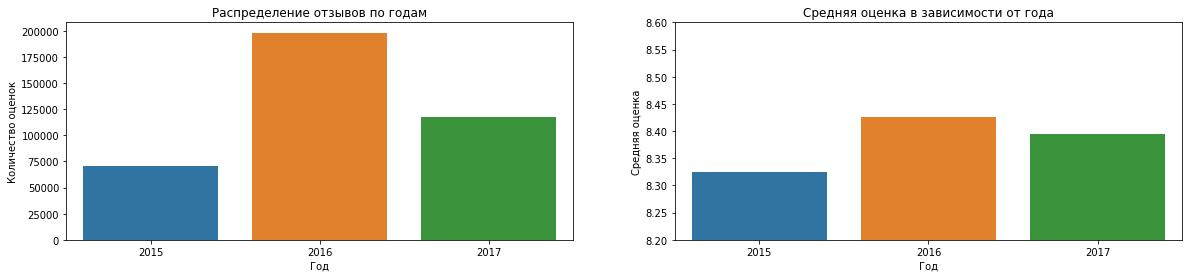

In [118]:
# Группируем данные, чтобы узнать количество отзывов по годам
groupped_year_count = data[data['sample']==1].groupby('year')['reviewer_score'].count()
# Группируем данные, чтобы узнать среднюю оценку по годам
groupped_year_mean = data[data['sample']==1].groupby('year')['reviewer_score'].mean()

fig, axes = plt.subplots(1, 2, figsize=(20, 4))

# Строим столбчатую диаграмму для визуализации количества отзывов по годам
sns.barplot( 
            groupped_year_count.index,
            groupped_year_count.values,
            ax=axes[0]
            )
axes[0].set(xlabel='Год', ylabel='Количество оценок')
axes[0].set_title('Распределение отзывов по годам')


# Строим столбчатую диаграмму для визуализации средней оценки в зависимости от года
sns.barplot( 
            groupped_year_mean.index,
            groupped_year_mean.values,
            ax=axes[1]
            )
axes[1].set(xlabel='Год', ylabel='Средняя оценка')
axes[1].set_title('Средняя оценка в зависимости от года')

plt.ylim(8.2, 8.6)
plt.show()

Количество оценок в 2016 году больше, чем в 2015 и 2017, так как в выборке представлены данные с августа 2015 по август 2017, таким образом 2016 год единственный полный год в данных. Средняя оценка в 2016 году выше, чем в другие годы.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



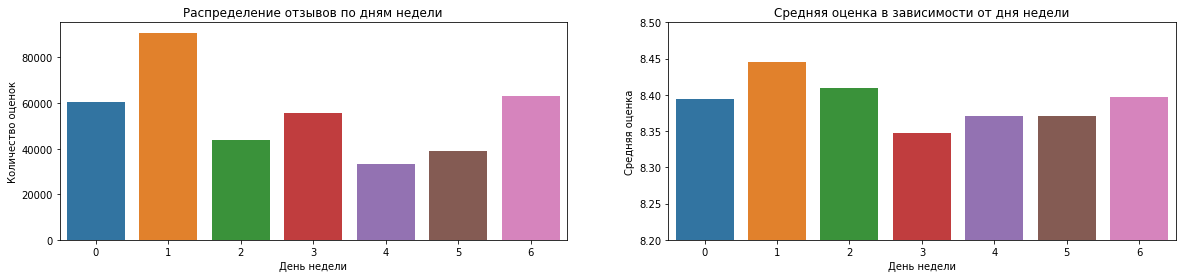

In [119]:
# Группируем данные, чтобы узнать количество отзывов по дням недели
groupped_dayofweek_count = data[data['sample']==1].groupby('dayofweek')['reviewer_score'].count()
# Группируем данные, чтобы узнать среднюю оценку по дням недели
groupped_dayofweek_mean = data[data['sample']==1].groupby('dayofweek')['reviewer_score'].mean()

fig, axes = plt.subplots(1, 2, figsize=(20, 4))

# Строим столбчатую диаграмму для визуализации количества отзывов по дням недели
sns.barplot( 
            groupped_dayofweek_count.index,
            groupped_dayofweek_count.values,
            ax=axes[0]
            )
axes[0].set(xlabel='День недели', ylabel='Количество оценок')
axes[0].set_title('Распределение отзывов по дням недели')


# Строим столбчатую диаграмму для визуализации средней оценки в зависимости от дня недели
sns.barplot( 
            groupped_dayofweek_mean.index,
            groupped_dayofweek_mean.values,
            ax=axes[1]
            )
axes[1].set(xlabel='День недели', ylabel='Средняя оценка')
axes[1].set_title('Средняя оценка в зависимости от дня недели')

plt.ylim(8.2, 8.5)
plt.show()

Самое больше количество оценок посетители оставляют во вторник, а также выделяются воскресенье и понедельник. Так как боьлшее количество рецензентов приезжали на отдых, то с большой долей вероятности они останавливались в отелях в выходные дни, соответственно по окончанию отдыха и ставили оценки. В эти же дни наблюдается и самая высокая средняя оценка.

# 4.Кодирование признаков

In [120]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 31 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515431 non-null  object        
 1   additional_number_of_scoring                515431 non-null  int64         
 2   review_date                                 515431 non-null  datetime64[ns]
 3   average_score                               515431 non-null  float64       
 4   hotel_name                                  515431 non-null  object        
 5   reviewer_nationality                        515431 non-null  object        
 6   negative_review                             515431 non-null  object        
 7   review_total_negative_word_counts           515431 non-null  int64         
 8   total_number_of_reviews                     515431 non-null  int64        

In [121]:
#data.describe(include = ['object'])

Закодируем номинальные признаки, количество уникальных значений которых меньше 15 - однократным кодированием.

In [122]:
# Кодируем признак страны где расположен отель
encoder = ce.OneHotEncoder(cols = ['hotel_country'], use_cat_names = True)
type_bin = encoder.fit_transform(data['hotel_country'])
data = pd.concat([data, type_bin], axis = 1)

In [123]:
# Кодируем признак цели поездки
encoder = ce.OneHotEncoder(cols = ['purpose_of_the_trip'], use_cat_names = True)
type_bin = encoder.fit_transform(data['purpose_of_the_trip'])
data = pd.concat([data, type_bin], axis = 1)

In [124]:
# Кодируем признак статуса рецензента
encoder = ce.OneHotEncoder(cols = ['status'], use_cat_names = True)
type_bin = encoder.fit_transform(data['status'])
data = pd.concat([data, type_bin], axis = 1)

Закодируем номинальные признаки, количество уникальных значений которых больше 15 - двоичным кодированием.

In [125]:
# Кодируем признак национальности рецензента
bin_encoder = ce.BinaryEncoder(cols = ['reviewer_nationality'])
type_bin = bin_encoder.fit_transform(data['reviewer_nationality'])
data = pd.concat([data, type_bin], axis = 1)

In [126]:
# Кодируем признак вида комнаты
bin_encoder = ce.BinaryEncoder(cols = ['room'])
type_bin = bin_encoder.fit_transform(data['room'])
data = pd.concat([data, type_bin], axis = 1)

In [127]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 57 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515431 non-null  object        
 1   additional_number_of_scoring                515431 non-null  int64         
 2   review_date                                 515431 non-null  datetime64[ns]
 3   average_score                               515431 non-null  float64       
 4   hotel_name                                  515431 non-null  object        
 5   reviewer_nationality                        515431 non-null  object        
 6   negative_review                             515431 non-null  object        
 7   review_total_negative_word_counts           515431 non-null  int64         
 8   total_number_of_reviews                     515431 non-null  int64        

# 5.Отбор признаков

Сначала удалим все признаки, из которых мы уже получили всю необходимую информацию.

In [128]:
data = data.drop(['hotel_address', 'review_date', 'hotel_name', 'reviewer_nationality', 'negative_review', 'positive_review', 'tags', 'lat', 'lng', 'hotel_country', 'tags_new', 'purpose_of_the_trip', 'room', 'status'], axis = 1)

Проверим признаки на мультиколлинеарность

<AxesSubplot:>

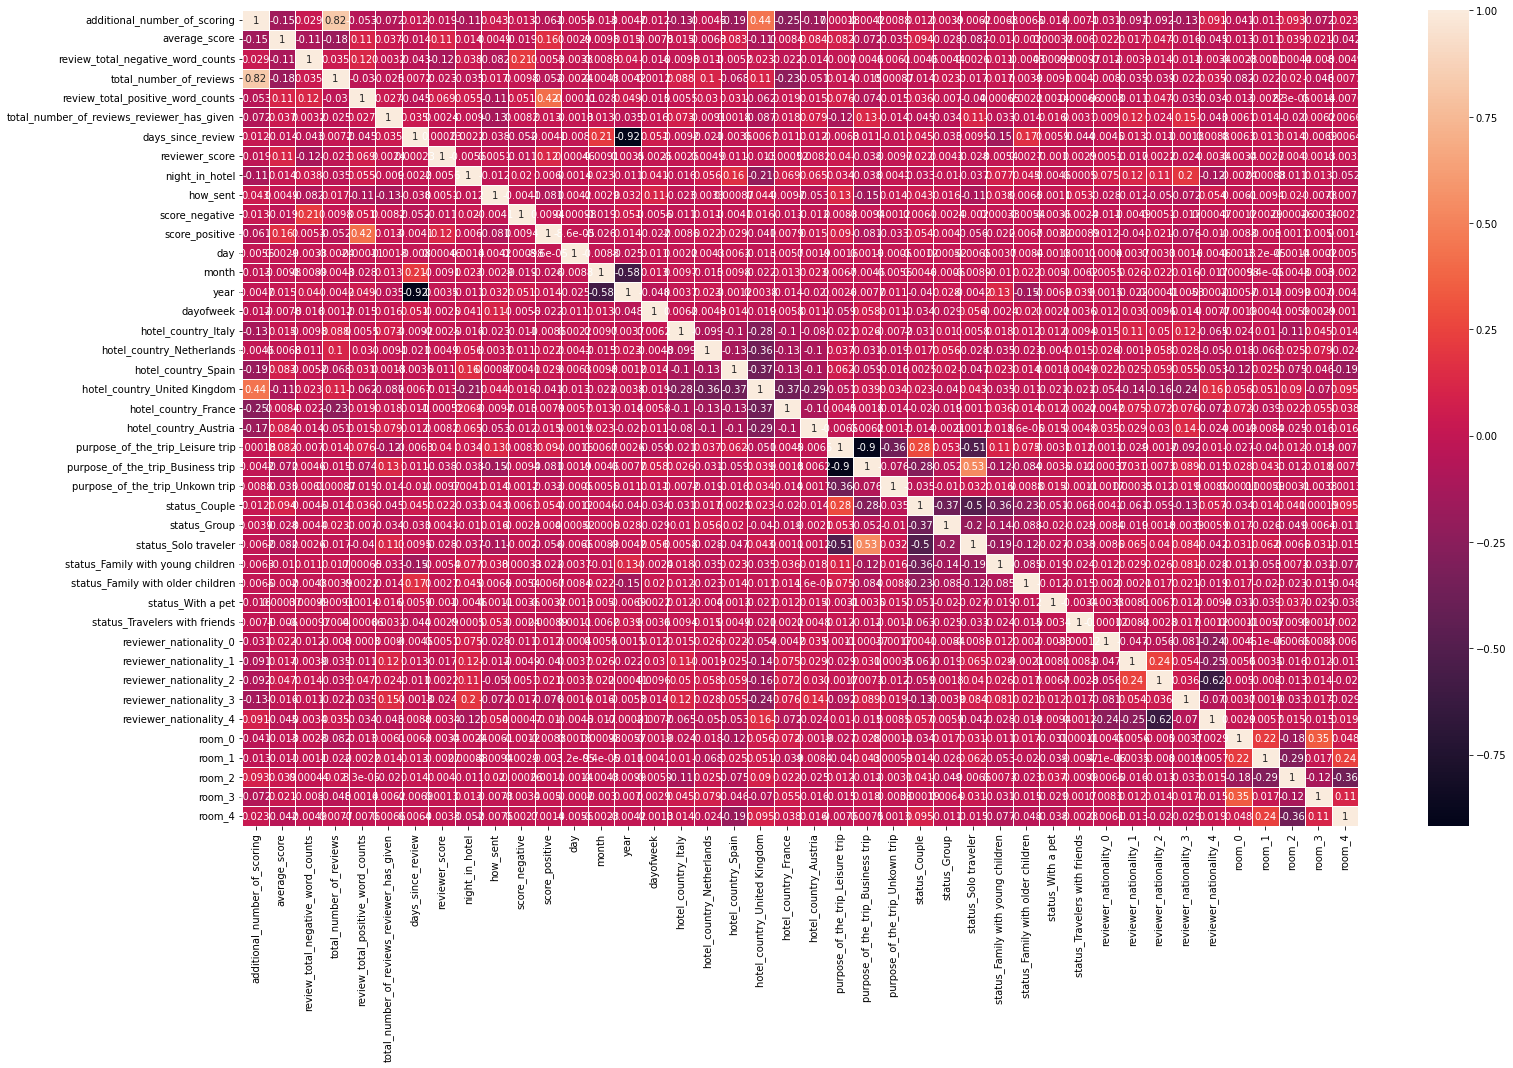

In [129]:
fig = plt.figure(figsize = (25,15))
sns.heatmap(data.drop(['sample'], axis=1).corr(), linewidth=.5, annot=True)

Удалим признаки с коэффициентом корреляции больше +/- 0.7

In [130]:
data = data.drop(['additional_number_of_scoring','year', 'purpose_of_the_trip_Business trip'], axis = 1)

In [131]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 40 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               515431 non-null  float64
 1   review_total_negative_word_counts           515431 non-null  int64  
 2   total_number_of_reviews                     515431 non-null  int64  
 3   review_total_positive_word_counts           515431 non-null  int64  
 4   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 5   days_since_review                           515431 non-null  int64  
 6   sample                                      515431 non-null  int64  
 7   reviewer_score                              515431 non-null  float64
 8   night_in_hotel                              515431 non-null  int64  
 9   how_sent                                    515431 non-null  int64  
 

Разделим признаки на категориальные и числовые

In [132]:
num_cols = ['average_score',
           'review_total_negative_word_counts',
           'total_number_of_reviews',
           'review_total_positive_word_counts',
           'total_number_of_reviews_reviewer_has_given',
           'days_since_review',
           'night_in_hotel',
           'score_negative',
           'score_positive']
cat_cols = ['day',
           'month',
           'dayofweek',
           'hotel_country_Italy',
           'hotel_country_Netherlands',
           'hotel_country_Spain',
           'hotel_country_United Kingdom',
           'hotel_country_France',
           'hotel_country_Austria',
           'purpose_of_the_trip_Leisure trip',
           'purpose_of_the_trip_Unkown trip',
           'status_Couple',
           'status_Group',
           'status_Solo traveler',
           'status_Family with young children',
           'status_Family with older children',
           'status_With a pet',
           'status_Travelers with friends',
           'reviewer_nationality_0',
           'reviewer_nationality_1',
           'reviewer_nationality_2',
           'reviewer_nationality_3',
           'reviewer_nationality_4',
           'room_0',
           'room_1',
           'room_2',
           'room_3',
           'room_4'
           ]

<AxesSubplot:>

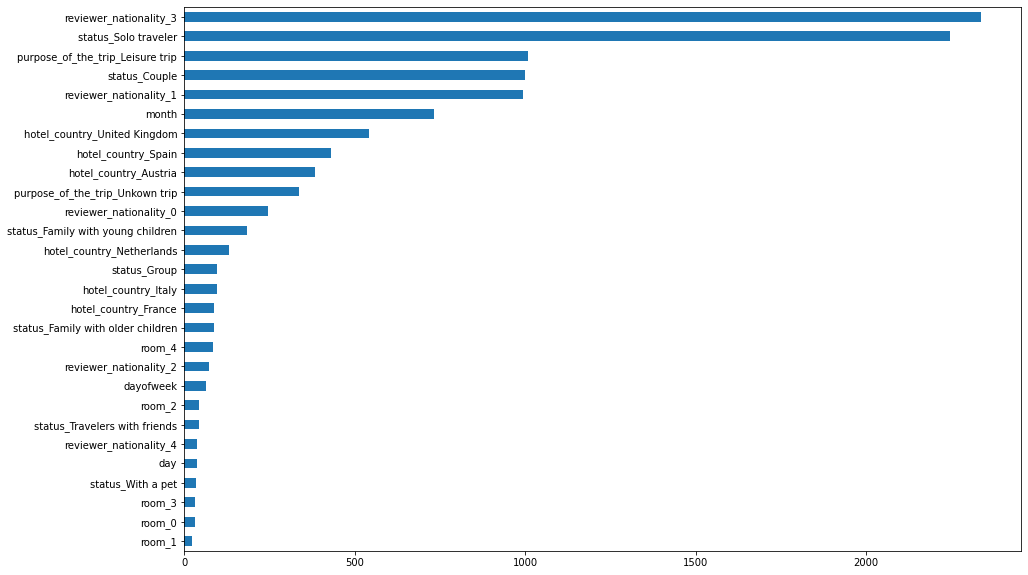

In [133]:
from sklearn.feature_selection import chi2

# Для оценки значимости категориальных переменных используем непараметрический тест хи-квадрат.
y = data.query('sample == 1').drop(['sample'], axis=1).reviewer_score.values.astype('int')
X = data.query('sample == 1').drop(['sample'], axis=1)[cat_cols]

# Выведем значения хи-квадрат на графике:
plt.rcParams['figure.figsize'] = (15,10)
imp_cat = pd.Series(chi2(X, y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [134]:
imp_cat

room_1                                 23.883006
room_0                                 31.503641
room_3                                 32.496756
status_With a pet                      34.352807
day                                    37.471570
reviewer_nationality_4                 38.960887
status_Travelers with friends          43.006544
room_2                                 43.975922
dayofweek                              64.240050
reviewer_nationality_2                 71.879105
room_4                                 85.004121
status_Family with older children      86.339136
hotel_country_France                   87.561657
hotel_country_Italy                    95.046373
status_Group                           95.885180
hotel_country_Netherlands             130.218251
status_Family with young children     185.482741
reviewer_nationality_0                245.304276
purpose_of_the_trip_Unkown trip       336.064787
hotel_country_Austria                 384.933358
hotel_country_Spain 

<AxesSubplot:>

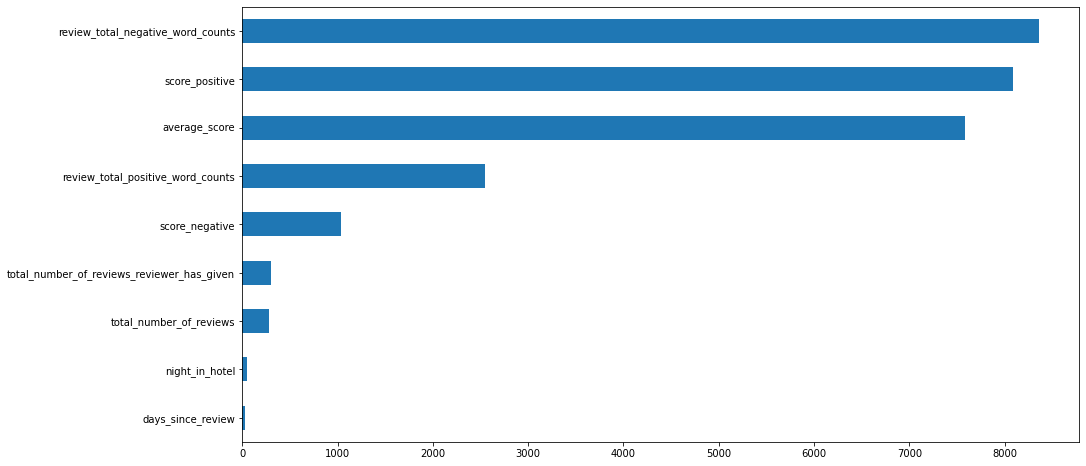

In [135]:
from sklearn.feature_selection import f_classif 

# Для оценки значимости непрерывных переменных будем используем f_classif из библиотеки sklearn.
y = data.query('sample == 1').drop(['sample'], axis=1).reviewer_score.values.astype('int')
X = data.query('sample == 1').drop(['sample'], axis=1)[num_cols]

# Выведем значения f_classif на графике:
plt.rcParams['figure.figsize'] = (15,8)
imp_num = pd.Series(f_classif(X, y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [136]:
imp_num

days_since_review                               26.722059
night_in_hotel                                  47.599910
total_number_of_reviews                        277.930171
total_number_of_reviews_reviewer_has_given     299.803806
score_negative                                1040.148073
review_total_positive_word_counts             2550.332232
average_score                                 7588.683414
score_positive                                8089.710480
review_total_negative_word_counts             8366.065720
dtype: float64

Удалим признаки с самой низкой значимостью

In [137]:
data = data.drop(['days_since_review','night_in_hotel', 'room_1', 'room_0', 'room_3', 'status_With a pet'], axis = 1)

# 6. Обучение модели

In [138]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 34 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               515431 non-null  float64
 1   review_total_negative_word_counts           515431 non-null  int64  
 2   total_number_of_reviews                     515431 non-null  int64  
 3   review_total_positive_word_counts           515431 non-null  int64  
 4   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 5   sample                                      515431 non-null  int64  
 6   reviewer_score                              515431 non-null  float64
 7   how_sent                                    515431 non-null  int64  
 8   score_negative                              515431 non-null  float64
 9   score_positive                              515431 non-null  float64
 

In [139]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [140]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [141]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 33), (386496, 33), (386496, 32), (309196, 32), (77300, 32))

In [142]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [143]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [144]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.8s finished


In [145]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))

MAPE: 0.8770294314359636


In [146]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [147]:
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MAPE: 12.5261559917866


<AxesSubplot:>

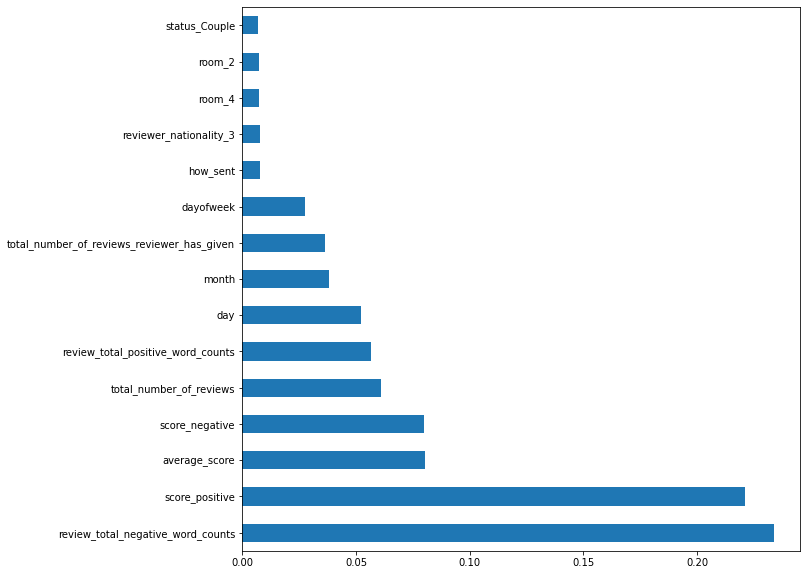

In [148]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [149]:
test_data.sample(10)

,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,how_sent,score_negative,score_positive,day,...,status_Family with young children,status_Family with older children,status_Travelers with friends,reviewer_nationality_0,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4,room_2,room_4
63744,8.1,0,1556,34,1,0.0,1,-0.7096,0.7003,9,...,0,0,0,0,0,0,0,1,1,0
13392,8.6,0,2277,22,5,0.0,1,-0.7096,-0.3052,22,...,0,0,0,0,1,0,0,1,1,0
70821,9.1,32,3883,106,6,0.0,0,0.6256,0.8709,20,...,0,0,0,0,1,0,0,1,0,1
99045,8.4,7,6117,6,1,0.0,1,0.0000,0.0000,17,...,1,0,0,0,1,0,0,0,1,0
35523,8.3,11,1207,6,40,0.0,0,0.0000,0.0000,23,...,0,0,0,0,1,0,1,1,1,0
101328,8.2,11,1827,6,1,0.0,1,0.4927,0.6124,29,...,0,0,0,0,0,0,0,1,0,1
112049,8.6,32,3486,9,7,0.0,0,0.0000,0.7650,14,...,0,0,0,0,0,0,0,1,0,1
49197,8.6,7,1257,25,2,0.0,0,0.5413,0.7579,5,...,1,0,0,0,0,1,1,1,1,0
58751,8.3,2,3308,13,5,0.0,0,0.0000,0.9535,28,...,0,0,0,0,0,0,0,1,1,0
34220,8.0,3,2907,8,1,0.0,1,0.0000,0.4215,15,...,0,0,0,0,0,0,0,1,1,0


In [150]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [151]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [152]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    3.0s finished


In [153]:
predict_submission

array([8.704, 7.399, 8.824, ..., 7.978, 9.394, 7.486])

In [154]:
list(sample_submission)

['reviewer_score', 'id']

In [155]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.704,488440
1,7.399,274649
2,8.824,374688
3,9.642,404352
4,9.431,451596
5,8.960,302161
6,7.899,317079
7,7.681,13963
8,8.285,159785
9,7.935,195089
